In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaboern as sns
import os
import json
from dataset import XRayDataset, XRayDataset_path
from torch.utils.data import DataLoader, Subset
import torch
import albumentations as A
import random
from tqdm.auto import tqdm
import torch.nn.functional as F
import torch.nn as nn

%matplotlib inline

In [2]:
IMAGE_ROOT = "/opt/ml/input/data/train/DCM/"
LABEL_ROOT = "/opt/ml/input/data/train/outputs_json/"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

BATCH_SIZE=8

In [3]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [6]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [8]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)
    
    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)


In [9]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [10]:
def make_dataset(debug="False"):
    # dataset load
    tf = A.Resize(512, 512)
    train_dataset = XRayDataset(is_train=True, transforms=tf)
    valid_dataset = XRayDataset(is_train=False, transforms=tf)
    original_dataset = XRayDataset_path(is_train=False)
    if debug=="True":
        train_subset_size = int(len(train_dataset) * 0.5)

        # Create a random train subset of the original dataset
        train_subset_indices = torch.randperm(len(train_dataset))[:train_subset_size]
        train_dataset = Subset(train_dataset, train_subset_indices)

        # Calculate the number of samples for the valid subset
        valid_subset_size = int(len(valid_dataset) * 0.5)

        # Create a random valid subset of the original dataset
        valid_subset_indices = torch.randperm(len(valid_dataset))[:valid_subset_size]
        valid_dataset = Subset(valid_dataset, valid_subset_indices)

        original_dataset = Subset(original_dataset, valid_subset_indices)
        
    train_loader = DataLoader(
        dataset=train_dataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8,
        drop_last=True,
    )

    valid_loader = DataLoader(
        dataset=valid_dataset, 
        batch_size=2,
        shuffle=False,
        num_workers=0,
        drop_last=False
    )

    original_loader = DataLoader(
        dataset=original_dataset, 
        batch_size=2,
        shuffle=False,
        num_workers=0,
        drop_last=False
    )

    return [train_loader, valid_loader, original_loader]

# Visualizing images

In [11]:
def validation(epoch, model, data_loader, criterion, thr=0.5):
    print(f'Start validation #{epoch:2d}')
    model.eval()

    dices = []
    all_dices = []
    all_masks = []
    with torch.no_grad():
        total_loss = 0
        cnt = 0
    
        for step, (images, masks) in tqdm(enumerate(data_loader)):
            images, masks = images.cuda(), masks.cuda()         
            model = model.cuda()
            
            outputs = model(images)
            
            output_h, output_w = outputs.size(-2), outputs.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)
            
            # restore original size
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")
            
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu()
            masks = masks.detach().cpu()
            all_masks.append(np.array(outputs))
            dice = dice_coef(outputs, masks)
            all_dices.append(dice.mean(axis=1))
            dices.append(dice)
    dices = torch.cat(dices, 0)
    return [all_masks, all_dices]

In [12]:
def save_image(epoch, data_loader):
    print(f'Start validation #{epoch:2d}')
    all_images=[]
    all_masks=[]
    all_paths=[]
    for step, (images, masks, path) in tqdm(enumerate(data_loader)):
        all_images.append(np.array(images))
        all_masks.append(np.array(masks))
        all_paths.append(path)
    return [all_images, all_masks, all_paths]

In [13]:
model = torch.load("/opt/ml/weights/MAnet/MAnet_resnet101_calc_loss_120.pt")

In [14]:
set_seed(21)
train_loader, valid_loader, original_loader = make_dataset(debug="True")
criterion = nn.BCEWithLogitsLoss()

In [15]:
masks, dices = validation(1, model, valid_loader, criterion)    #메모리 이슈로 이미지 절반(40)만 추출합니다

Start validation # 1


In [16]:
gtimage, gtmask, gtpath = save_image(1, original_loader)

Start validation # 1


In [17]:
masks = np.concatenate(masks, axis=0)   #predicetd mask
dices = np.concatenate(dices, axis=0)   #predicted labels' dices
gtimage = np.concatenate(gtimage, axis=0)   #GT image(2048, 2048)
gtmask = np.concatenate(gtmask, axis=0)    #GT mask(2048, 2048)
gtpath = np.concatenate(gtpath, axis=0)     #image path

In [18]:
print(masks.shape)
print(dices.shape)
print(gtimage.shape)
print(gtmask.shape)
print(gtpath.shape)

(80, 29, 2048, 2048)
(80,)
(80, 3, 2048, 2048)
(80, 29, 2048, 2048)
(80,)


In [19]:
gtpath = [i.split("/")[-2]+"_"+i.split("/")[-1] for i in gtpath]

In [20]:
tp = np.logical_and(gtmask, masks)
fn = gtmask - masks
fp = masks - gtmask

In [ ]:
#이미지 저장경로 설정
model_path = "MAnet/"     #원하는 폴더명 입력
path = "/opt/ml/statimages/"
path = os.path.join(path, model_path)

if not os.path.isdir(path):                                                           
    os.makedirs(path, exist_ok=True)

KeyboardInterrupt: 

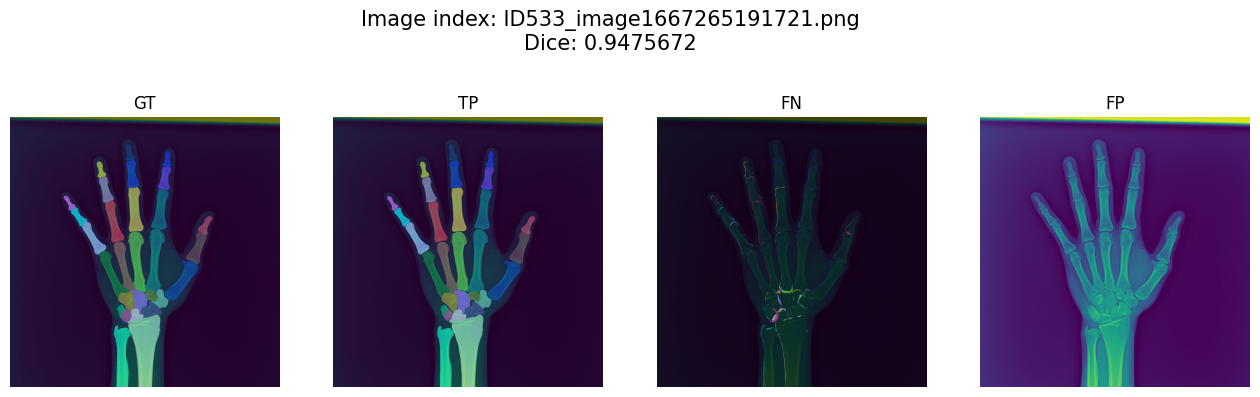

In [ ]:
for i in tqdm(range(len(dices))):
    INDEX = i

    fig, ax = plt.subplots(1, 4, figsize=(16, 5))
    ax = ax.flatten()
    fig.suptitle("Image index: " + str(gtpath[INDEX]) +"\nDice: " + str(dices[INDEX]), fontsize=15)
    ax[0].imshow(gtimage[INDEX][0])   # remove channel dimension
    ax[1].imshow(gtimage[INDEX][0])   # remove channel dimension
    ax[2].imshow(gtimage[INDEX][0])   # remove channel dimension
    ax[3].imshow(gtimage[INDEX][0])   # remove channel dimension
    ax[0].axis("off")
    ax[1].axis("off")
    ax[2].axis("off")
    ax[3].axis("off")
    ax[0].set_title("GT")
    ax[1].set_title("TP")
    ax[2].set_title("FN")
    ax[3].set_title("FP")


    ax[0].imshow(label2rgb(gtmask[INDEX]), alpha=0.5)
    ax[1].imshow(label2rgb(tp[INDEX]), alpha=0.5)
    ax[2].imshow(label2rgb(fn[INDEX]), alpha=0.7)
    ax[3].imshow(label2rgb(fp[INDEX]), alpha=0.7)

    plt.savefig(f"{path}{str(dices[INDEX])}_{gtpath[INDEX]}", dpi=300, bbox_inches = "tight")
    plt.close(fig) 